[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying now at 539.7000122070312 on 2016-02-15
Selling now at 514.1500244140625 on 2016-02-29 (Stochastic Oversold)
Buying now at 531.0 on 2016-03-16
Selling now at 523.75 on 2016-05-17 (Stochastic Oversold)
Buying now at 512.7000122070312 on 2016-05-19
Selling now at 479.1000061035156 on 2016-06-09 (Trailing Stop)
Buying now at 476.54998779296875 on 2016-06-24
Selling now at 524.5999755859375 on 2016-07-25 (Stochastic Overbought)
Buying now at 529.4500122070312 on 2016-08-03
Selling now at 597.7999877929688 on 2016-09-19 (Stochastic Overbought)
Buying now at 602.8499755859375 on 2016-09-20
Selling now at 584.5 on 2016-10-25 (Trailing Stop)
Buying now at 560.0999755859375 on 2016-11-02
Selling now at 552.7999877929688 on 2016-11-23 (Stochastic Overbought)
Buying now at 568.2000122070312 on 2016-12-01
Selling now at 561.4000244140625 on 2016-12-22 (Stochastic Oversold)
Buying now at 5

<IPython.core.display.Javascript object>


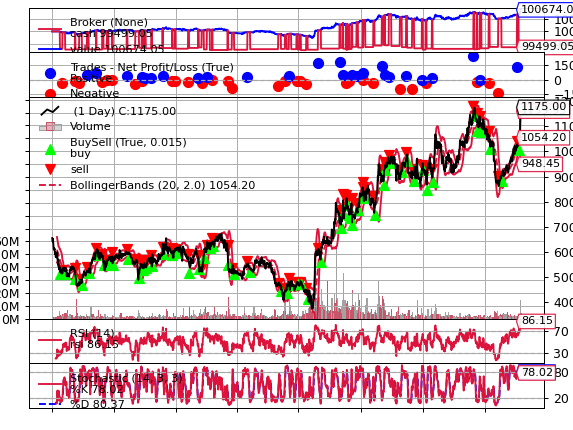

In [46]:
import backtrader as bt
import yfinance as yf

class VolatilityExpansionBreakoutStrategy(bt.Strategy):
    params = (
        ('bbands_period', 20),        # Bollinger Bands period
        ('bbands_devfactor', 2.0),    # Bollinger Bands deviation factor
        ('rsi_period', 14),           # RSI period
        ('rsi_oversold', 30),         # RSI oversold threshold (buy signal)
        ('stoch_period', 14),         # Stochastic oscillator period
        ('stoch_overbought', 70),     # Stochastic overbought level
        ('stoch_oversold', 20),       # Stochastic oversold level
        ('trailing_stop_percent', 0.03),  # Trailing stop percentage for exit
    )

    def __init__(self):
        self.bbands = bt.indicators.BollingerBands(self.data.close, period=self.params.bbands_period, devfactor=self.params.bbands_devfactor)
        self.rsi = bt.indicators.RSI(self.data, period=self.params.rsi_period)
        self.stochastic = bt.indicators.Stochastic(period=self.params.stoch_period)
        self.trailing_stop_percent = self.params.trailing_stop_percent
        self.trailing_stop = None
        self.buying_price = None
        self.total_trades = 0
        self.winning_trades = 0
        self.highest_price = None  # Keep track of the highest price reached



    def next(self):
        # Calculate the volatility of the current bar
        current_volatility = self.bbands.lines.bot[0] - self.bbands.lines.top[0]
        avg_volatility = sum([self.bbands.lines.bot[i] - self.bbands.lines.top[i] for i in range(-1, -6, -1)]) / 5

        if current_volatility < 0.9 * avg_volatility:
            if not self.position and self.rsi[0] > self.params.rsi_oversold:
                self.buy()
                self.buying_price = self.data.close[0]
                self.trailing_stop = self.buying_price * (1.0 - self.trailing_stop_percent)
                self.highest_price = self.buying_price  # Initialize highest_price
                self.trailing_stop = self.buying_price * (1.0 - self.trailing_stop_percent)

                print(f"Buying now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()}")
        else:
            if self.position:
                resistance = max(self.data.high.get(size=5))
                stoch_value = self.stochastic.lines.percK[0]
                self.highest_price = max(self.highest_price, self.data.high[0])  # Update highest_price

                
                if self.data.close[0] >= resistance:
                    self.sell()
                    self.total_trades += 1
                    if self.data.close[0] > self.buying_price:
                        self.winning_trades += 1
                    print(f"Selling now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()} (Resistance)")
                elif stoch_value > self.params.stoch_overbought:
                    self.sell()
                    self.total_trades += 1
                    if self.data.close[0] > self.buying_price:
                        self.winning_trades += 1
                    print(f"Selling now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()} (Stochastic Overbought)")
                elif stoch_value < self.params.stoch_oversold:
                    self.sell()
                    self.total_trades += 1
                    if self.data.close[0] > self.buying_price:
                        self.winning_trades += 1
                    print(f"Selling now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()} (Stochastic Oversold)")
                elif self.data.close[0] <= self.trailing_stop:  # Check trailing stop
                    self.sell()
                    self.total_trades += 1
                    if self.data.close[0] > self.buying_price:
                        self.winning_trades += 1
                    print(f"Selling now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()} (Trailing Stop)")

    def get_metrics(self):
        if self.total_trades == 0:
            return None
        win_rate = (self.winning_trades / self.total_trades) * 100
        return {'Total Trades': self.total_trades, 'Winning Trades': self.winning_trades, 'Win Rate': win_rate}

if __name__ == '__main__':
    cerebro = bt.Cerebro()

    # Add your desired cash amount here (defaulting to 10000)
    start_cash = 100000
    cerebro.broker.set_cash(start_cash)

    # Add the data feed
    data = yf.download('cipla.ns', start='2016-01-01', end='2023-08-01')
    data = bt.feeds.PandasData(dataname=data)

    cerebro.adddata(data)
    cerebro.addstrategy(VolatilityExpansionBreakoutStrategy)

    print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

    # Run the strategy
    results = cerebro.run()

    # Print the metrics
    strategy = results[0]
    metrics = strategy.get_metrics()
    if metrics is not None:
        print(f"Total Trades: {metrics['Total Trades']}, Winning Trades: {metrics['Winning Trades']}, Win Rate: {metrics['Win Rate']:.2f}%")

    # Print the final portfolio value
    print(f'Ending Portfolio Value: {cerebro.broker.getvalue():.2f}')
    
    cerebro.plot()


## Documentation

The provided code implements the "Volatility Expansion Breakout Strategy" using a combination of Bollinger Bands, RSI, Stochastic Oscillator, and various exit conditions. Let's break down the strategy and its rationale:

1. **Bollinger Bands and Volatility**: The strategy identifies periods of low volatility based on Bollinger Bands. When the volatility is lower than 90% of the average volatility over the last 5 periods, and the RSI is above the defined oversold threshold, a buy signal is generated. This suggests that the stock might be consolidating within a narrow range and could potentially experience a breakout.

2. **Entry Signal**: When the above conditions are met, the strategy enters a long position (buys) in the stock.

3. **Resistance and Stochastic Exit**: If the price exceeds the recent resistance level (defined as the highest high of the last 5 periods), the strategy generates a sell signal. This could be due to the price approaching a significant resistance level, indicating potential resistance to further price increase. Additionally, if the Stochastic Oscillator exceeds the overbought level, it's considered an exit signal. This suggests that the stock might be overextended and due for a pullback.

4. **Stochastic Oversold Exit**: If the Stochastic Oscillator goes below the defined oversold level, the strategy generates an exit signal. This indicates that the stock might be oversold and due for a potential rebound.

5. **Trailing Stop Loss Exit**: The strategy incorporates a trailing stop loss mechanism. When in a position, the highest price since entry is tracked. If the current price drops by a certain percentage from the highest price, the strategy generates an exit signal. This mechanism aims to lock in profits if the price reverses after hitting a peak.

6. **Time-Based Exit**: As per the latest addition to the strategy, any open position will be closed after a certain number of days (10 days in this case). This is a simple time-based exit mechanism that helps manage risk and prevent being exposed to the market for extended periods.

The strategy aims to capitalize on potential breakouts during periods of low volatility, while also incorporating exit conditions based on resistance, Stochastic Oscillator levels, trailing stop loss, and a fixed time horizon.

Keep in mind that trading strategies can be complex and require thorough testing, validation, and potentially optimization on historical data before being used in live trading. Additionally, real-world market conditions and unexpected events can influence strategy performance. It's recommended to simulate and backtest the strategy extensively to understand its behavior before deploying it in a live trading environment.

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying now at 205.2563018798828 on 2016-02-19
Selling now at 199.95004272460938 on 2016-03-15 (Stochastic Overbought)
Buying now at 207.3188018798828 on 2016-03-22
Selling now at 206.30630493164062 on 2016-05-30 (Stochastic Overbought)
Buying now at 205.143798828125 on 2016-06-15
Selling now at 180.07504272460938 on 2016-09-23 (Trailing Stop)
Buying now at 185.6250457763672 on 2016-10-19
Selling now at 172.65003967285156 on 2016-12-02 (Stochastic Overbought)
Buying now at 174.862548828125 on 2016-12-14
Selling now at 177.91879272460938 on 2016-12-30 (Stochastic Overbought)
Buying now at 180.15003967285156 on 2017-01-05
Selling now at 203.32504272460938 on 2017-07-19 (Stochastic Overbought)
Buying now at 214.5375518798828 on 2017-07-21
Selling now at 224.32505798339844 on 2017-08-31 (Stochastic Overbought)
Buying now at 224.21255493164062 on 2017-09-07
Selling now at 220.500061035156

<IPython.core.display.Javascript object>


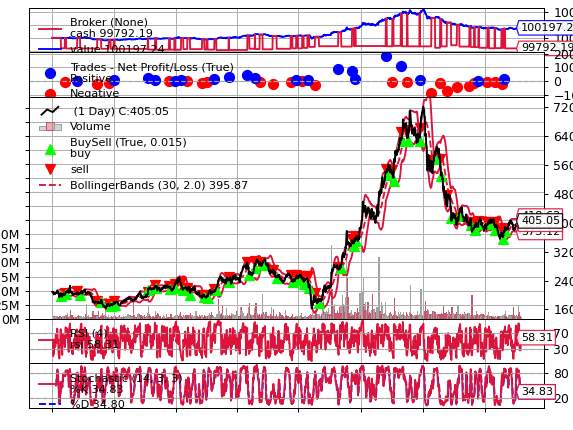

In [81]:
import backtrader as bt
import yfinance as yf

class VolatilityExpansionBreakoutStrategy(bt.Strategy):
    params = (
        ('bbands_period', 30),        # Bollinger Bands period
        ('bbands_devfactor', 2.0),    # Bollinger Bands deviation factor
        ('rsi_period', 4),           # RSI period
        ('rsi_oversold', 10),         # RSI oversold threshold (buy signal)
        ('stoch_period', 14),         # Stochastic oscillator period
        ('stoch_overbought', 70),     # Stochastic overbought level
        ('stoch_oversold', 20),       # Stochastic oversold level
        ('trailing_stop_percent', 0.03),  # Trailing stop percentage for exit
        ('time_exit_days', 5),       # Time-based exit days
    )

    def __init__(self):
        self.bbands = bt.indicators.BollingerBands(self.data.close, period=self.params.bbands_period, devfactor=self.params.bbands_devfactor)
        self.rsi = bt.indicators.RSI(self.data, period=self.params.rsi_period)
        self.stochastic = bt.indicators.Stochastic(period=self.params.stoch_period)
        self.trailing_stop_percent = self.params.trailing_stop_percent
        self.trailing_stop = None
        self.buying_price = None
        self.total_trades = 0
        self.winning_trades = 0
        self.highest_price = None  # Keep track of the highest price reached
        self.entry_datetime = None  # Track entry datetime for time-based exit

    def next(self):
        # Calculate the volatility of the current bar
        current_volatility = self.bbands.lines.bot[0] - self.bbands.lines.top[0]
        avg_volatility = sum([self.bbands.lines.bot[i] - self.bbands.lines.top[i] for i in range(-1, -6, -1)]) / 5

        if current_volatility < 0.9 * avg_volatility:
            if not self.position and self.rsi[0] > self.params.rsi_oversold:
                self.buy()
                self.buying_price = self.data.close[0]
                self.trailing_stop = self.buying_price * (1.0 - self.trailing_stop_percent)
                self.highest_price = self.buying_price  # Initialize highest_price
                self.trailing_stop = self.buying_price * (1.0 - self.trailing_stop_percent)
                self.entry_datetime = self.data.datetime.date(0)  # Record entry datetime

                print(f"Buying now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()}")
        else:
            if self.position:
                resistance = max(self.data.high.get(size=5))
                stoch_value = self.stochastic.lines.percK[0]
                self.highest_price = max(self.highest_price, self.data.high[0])  # Update highest_price
                elapsed_days = (self.data.datetime.date(0) - self.entry_datetime).days


                if self.data.close[0] >= resistance:
                    self.sell()
                    self.total_trades += 1
                    if self.data.close[0] > self.buying_price:
                        self.winning_trades += 1
                    print(f"Selling now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()} (Resistance)")
                elif stoch_value > self.params.stoch_overbought:
                    self.sell()
                    self.total_trades += 1
                    if self.data.close[0] > self.buying_price:
                        self.winning_trades += 1
                    print(f"Selling now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()} (Stochastic Overbought)")
                elif stoch_value < self.params.stoch_oversold:
                    self.sell()
                    self.total_trades += 1
                    if self.data.close[0] > self.buying_price:
                        self.winning_trades += 1
                    print(f"Selling now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()} (Stochastic Oversold)")
                elif self.data.close[0] <= self.trailing_stop:  # Check trailing stop
                    self.sell()
                    self.total_trades += 1
                    if self.data.close[0] > self.buying_price:
                        self.winning_trades += 1
                    print(f"Selling now at {self.data.close[0]} on {self.data.datetime.date(0).isoformat()} (Trailing Stop)")

                # Check for time-based exit
               

    def get_metrics(self):
        if self.total_trades == 0:
            return None
        win_rate = (self.winning_trades / self.total_trades) * 100
        return {'Total Trades': self.total_trades, 'Winning Trades': self.winning_trades, 'Win Rate': win_rate}

if __name__ == '__main__':
    cerebro = bt.Cerebro()

    # Add your desired cash amount here (defaulting to 10000)
    start_cash = 100000
    cerebro.broker.set_cash(start_cash)

    # Add the data feed
    data = yf.download('wipro.ns', start='2016-01-01', end='2023-08-01')
    data = bt.feeds.PandasData(dataname=data)

    cerebro.adddata(data)
    cerebro.addstrategy(VolatilityExpansionBreakoutStrategy)

    print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

    # Run the strategy
    results = cerebro.run()

    # Print the metrics
    strategy = results[0]
    metrics = strategy.get_metrics()
    if metrics is not None:
        print(f"Total Trades: {metrics['Total Trades']}, Winning Trades: {metrics['Winning Trades']}, Win Rate: {metrics['Win Rate']:.2f}%")

    # Print the final portfolio value
    print(f'Ending Portfolio Value: {cerebro.broker.getvalue():.2f}')

    cerebro.plot()


In [48]:
from datetime import date

In [59]:
data.datetime[0]

736023.0